## Import Library

In [143]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Load Dataset

Load dataset merupakan proses memasukkan data dari sumber eksternal seperti file CSV ke dalam lingkungan kerja seperti Google Colab. Data biasanya dimuat ke dalam bentuk DataFrame menggunakan pustaka pandas agar bisa digunakan untuk analisis, visualisasi, atau pelatihan model machine learning. Langkah ini dilakukan di awal agar seluruh data tersedia dan siap digunakan dalam proses selanjutnya.


**Informasi Dataset**

| **Field** | **Value** |
|---------- |-----------|
| **Title** |Movie Lens Dataset           |
|**Source**| Kaggle                                                                    |
| **Maintainer**   | Hari Haran S                                                  |
| **License**      | Data files © Original Authors                                          |
| **Visibility**   | Publik                                                                    |
| **Tags**         | Earth and Nature, Arts and Entertainment, Movies and TV Shows |
| **Usability**    | 10.00    

In [144]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"eviafiyatus","key":"1c589be636b2247f76c6e97cf60fd0df"}'}

In [145]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [146]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aigamer/movie-lens-dataset
!unzip movie-lens-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/aigamer/movie-lens-dataset
License(s): copyright-authors
movie-lens-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-lens-dataset.zip
replace links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [147]:
links = pd.read_csv('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Pada dataset links terdapat 3 kolom. yaitu:

*   **MovieId** : ID unik untuk setiap film di dataset (digunakan internal dalam dataset).
*   **imdbId** : ID film dari situs IMDb (Internet Movie Database).
*   **tmdbId** : ID film dari situs TMDb (The Movie Database).

In [148]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Pada dataset movies terdapat 3 kolom. yaitu:

*   **MovieId** : ID unik untuk setiap film di dataset (digunakan internal dalam dataset).
*   **title** : Judul lengkap film.
*   **genres** : Daftar genre film, dipisahkan tanda |

In [149]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Pada dataset ratings terdapat 4 kolom. yaitu:

*   **userId** : ID unik pengguna yang memberikan rating.
*   **MovieId** : ID film yang diberi rating.
*   **rating** : Nilai rating yang diberikan user ke film (0.5–5.0).
*   **timestamp** : Waktu saat rating diberikan

In [150]:
tags = pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Pada dataset tags terdapat 4 kolom. yaitu:

*   **userId** : ID pengguna yang memberi tag.
*   **MovieId** : ID film yang diberi tag.
*   **tags** : Kata kunci yang diberikan pengguna untuk film tersebut.
*   **timestamp** : Waktu saat tag diberikan.

## Exploratory Data Analysis - Deskripsi Variabel

**Eksplorasi Links Variabel**

In [151]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


Berdasarkan hasil eksekusi method df.info() untuk dataframe links, terdapat 2 kolom bertipe data numerik integer, yaitu movieId dan imdbId. Selain itu, ada 1 kolom bertipe data float64, yaitu tmdbId.

In [152]:
print(links.describe())

             movieId        imdbId         tmdbId
count    9742.000000  9.742000e+03    9734.000000
mean    42200.353623  6.771839e+05   55162.123793
std     52160.494854  1.107228e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3248.250000  9.518075e+04    9665.500000
50%      7300.000000  1.672605e+05   16529.000000
75%     76232.000000  8.055685e+05   44205.750000
max    193609.000000  8.391976e+06  525662.000000


In [153]:
links.shape

(9742, 3)

Berdasarkan hasil eksekusi method df.shape, terdapat 9742 baris dan 3 kolom

**Eksplorasi Movies Variabel**

In [154]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan hasil eksekusi method df.info() untuk dataframe movies, terdapat 1 kolom bertipe data numerik integer, yaitu movieId. Selain itu, ada 2 kolom bertipe object, yaitu title dan genres.

In [155]:
print(movies.describe())

             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


In [156]:
movies.shape

(9742, 3)

Berdasarkan hasil eksekusi method df.shape, terdapat 9742 baris dan 3 kolom

In [157]:
print('Jumlah movie:', movies.movieId.nunique())
print('Jumlah title:', movies.title.nunique())
print('Jumlah genre:', movies.genres.nunique())

Jumlah movie: 9742
Jumlah title: 9737
Jumlah genre: 951


In [158]:
print(sorted(movies['genres'].unique()))

['(no genres listed)', 'Action', 'Action|Adventure', 'Action|Adventure|Animation', 'Action|Adventure|Animation|Children', 'Action|Adventure|Animation|Children|Comedy', 'Action|Adventure|Animation|Children|Comedy|Fantasy', 'Action|Adventure|Animation|Children|Comedy|IMAX', 'Action|Adventure|Animation|Children|Comedy|Romance', 'Action|Adventure|Animation|Children|Comedy|Sci-Fi', 'Action|Adventure|Animation|Children|Comedy|Sci-Fi|IMAX', 'Action|Adventure|Animation|Children|Comedy|Western', 'Action|Adventure|Animation|Children|Fantasy', 'Action|Adventure|Animation|Children|Fantasy|Sci-Fi', 'Action|Adventure|Animation|Children|Sci-Fi', 'Action|Adventure|Animation|Comedy', 'Action|Adventure|Animation|Comedy|Crime|Mystery', 'Action|Adventure|Animation|Comedy|Fantasy|Mystery|Sci-Fi', 'Action|Adventure|Animation|Comedy|Fantasy|Sci-Fi', 'Action|Adventure|Animation|Comedy|Sci-Fi', 'Action|Adventure|Animation|Comedy|Thriller', 'Action|Adventure|Animation|Crime|Fantasy', 'Action|Adventure|Animation

**Eksplorasi Ratings Variabel**

In [159]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan hasil eksekusi method df.info() untuk dataframe ratings, terdapat 3 kolom bertipe data numerik integer, yaitu userId, movieId, dan timestamp. Selain itu, ada 1 kolom bertipe data float64, yaitu rating.

In [160]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [161]:
ratings.shape

(100836, 4)

Berdasarkan hasil eksekusi method df.shape, terdapat 100836 baris dan 4 kolom

In [162]:
print('Jumlah Rating Unik:', ratings.rating.nunique())

Jumlah Rating Unik: 10


In [163]:
print(sorted(ratings['rating'].unique()))

[np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


**Eksplorasi Tags Variabel**

In [164]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Berdasarkan hasil eksekusi method df.info() untuk dataframe tags, terdapat 3 kolom bertipe data numerik integer, yaitu userId, movieId, dan timestamp. Selain itu, ada 1 kolom bertipe data float64, yaitu tag.

In [165]:
print(tags.describe())

            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09


In [166]:
tags.shape

(3683, 4)

Berdasarkan hasil eksekusi method df.shape, terdapat 3683 baris dan 4 kolom

In [167]:
print('Jumlah Tag:', tags.tag.nunique())

Jumlah Tag: 1589


In [168]:
print(sorted(tags['tag'].unique()))

['"artsy"', '06 Oscar Nominated Best Movie - Animation', '1900s', '1920s', '1950s', '1960s', '1970s', '1980s', '1990s', '2001-like', '2D animation', '70mm', "80's", 'AIDs', 'AS Byatt', 'AWESOME', 'Aardman', 'Academy award (Best Supporting Actress)', 'Action', 'Adam Sandler', 'Adrien Brody', 'Adventure', 'Afghanistan', 'Africa', 'Agatha Christie', 'Al Pacino', 'Alcatraz', 'Alfred Hitchcock', 'Alicia Vikander', 'Amazing Cinematography', 'American Indians', 'American propaganda', 'Amish', 'Amtrak', 'Amy Adams', 'Andrew Lloyd Weber', 'Andy Garcia', 'Andy Kaufman', 'Andy Samberg', 'Angelina Jolie', 'Animal movie', 'Animation', 'Anne Boleyn', 'Anne Hathaway', 'Anthony Hopkins', 'Arnold Schwarzenegger', 'Arthur C. Clarke', 'Arthur Miller', 'Astaire and Rogers', 'Atmospheric', 'Atomic bomb', 'Audrey Tautou', 'Australia', 'BEST PICTURE', 'Backwards. memory', 'Bad story', 'Bad writing', 'Batman', 'Beatles', 'Beautiful', 'Bechdel Test:Fail', 'Beethoven', 'Ben Affleck', 'Ben Kingsley', 'Ben Stille

## Exploratory Data Analysis Menangani Missing Value

Menghitung jumlah nilai yang hilang (missing values) di setiap kolom pada **DataFrame links**

In [169]:
links.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,8


Menghitung Jumlah baris data yang duplikat di dalam **DataFrame links**

In [170]:
print("Duplikat di links:", links.duplicated().sum())

Duplikat di links: 0


Menghitung jumlah nilai yang hilang (missing values) di setiap kolom pada **DataFrame movies**

In [171]:
movies.isnull().sum()

,0
movieId,0
title,0
genres,0



Menghitung Jumlah baris data yang duplikat di dalam **DataFrame movies**

In [172]:
print("Duplikat di movies:", movies.duplicated().sum())

Duplikat di movies: 0


Menghitung jumlah nilai yang hilang (missing values) di setiap kolom pada **DataFrame ratings**

In [173]:
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0



Menghitung Jumlah baris data yang duplikat di dalam **DataFrame ratings**

In [174]:
print("Duplikat di ratings:", ratings.duplicated().sum())

Duplikat di ratings: 0


Menghitung jumlah nilai yang hilang (missing values) di setiap kolom pada **DataFrame tags**

In [175]:
tags.isnull().sum()

,0
userId,0
movieId,0
tag,0
timestamp,0



Menghitung Jumlah baris data yang duplikat di dalam **DataFrame tags**

In [176]:
print("Duplikat di tags:", tags.duplicated().sum())

Duplikat di tags: 0


## Exploratory Data Analysis Lanjutan

Jumlah rating per user dan film

In [177]:
user_counts = ratings['userId'].value_counts()
print('Jumlah user unik yang memberikan rating:', ratings['userId'].nunique())

movie_counts = ratings['movieId'].value_counts()
print('Jumlah film unik yang diberi rating:', ratings['movieId'].nunique())

Jumlah user unik yang memberikan rating: 610
Jumlah film unik yang diberi rating: 9724


Menyaring user aktif (≥20 rating) untuk meningkatkan kualitas data rekomendasi.

In [178]:
user_counts = ratings['userId'].value_counts()

popular_users = user_counts[user_counts >= 20].index
filtered_data = ratings[ratings['userId'].isin(popular_users)]

print("Jumlah data setelah filter:", len(filtered_data))
print("Jumlah user unik setelah filter:", filtered_data['userId'].nunique())

Jumlah data setelah filter: 100836
Jumlah user unik setelah filter: 610


Menghitung Rata-Rata ratings

In [179]:
mean_rating = ratings['rating'].mean()
print(f'Nilai rata-rata rating film: {mean_rating:.2f}')

Nilai rata-rata rating film: 3.50


Visualisasi grafik distribusi skor rating

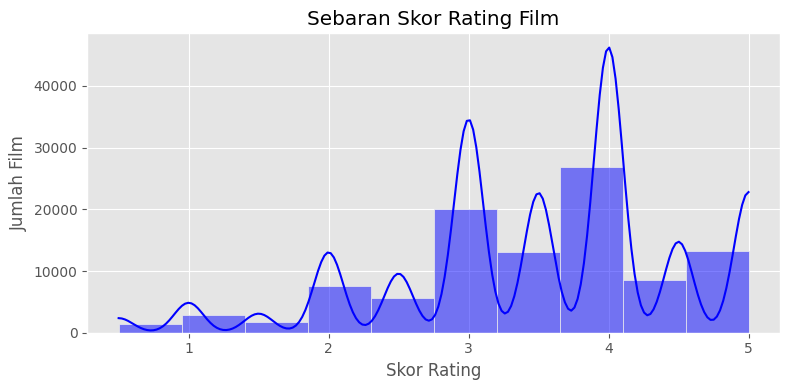

In [180]:
plt.figure(figsize=(8, 4))
sns.histplot(data=ratings, x='rating', bins=10, kde=True, color='blue')
plt.title('Sebaran Skor Rating Film')
plt.xlabel('Skor Rating')
plt.ylabel('Jumlah Film')
plt.tight_layout()
plt.show()

Secara keseluruhan, gambar grafik diatas menggambarkan bahwa penonton cenderung memberikan rating yang positif atau cukup positif terhadap film. Mayoritas film mendapatkan rating 3, 4, atau 5 bintang, dengan 4 bintang menjadi rating yang paling sering diberikan. Ini bisa berarti bahwa rata-rata film yang tersedia memiliki kualitas yang dianggap "baik" oleh sebagian besar penonton, atau bahwa penonton cenderung memberikan rating yang lebih tinggi.

Menampilkan 20 Film Teratas Berdasarkan Jumlah Rating

In [181]:
# Hitung jumlah rating per film dan gabungkan dengan judul film
rating_per_film = ratings['movieId'].value_counts()
rating_per_film = pd.merge(rating_per_film, movies[['movieId', 'title']], left_index=True, right_on='movieId')
rating_per_film = rating_per_film.rename(columns={'movieId_x': 'movieId', 'count': 'total_rating'})

# Urutkan film berdasarkan jumlah rating terbanyak
top_rated_films = rating_per_film.sort_values(by='total_rating', ascending=False)

print("20 Film Teratas Berdasarkan Jumlah Rating:\n ")
print(top_rated_films.head(20))

20 Film Teratas Berdasarkan Jumlah Rating:
 
      total_rating  movieId                                              title
314            329      356                                Forrest Gump (1994)
277            317      318                   Shawshank Redemption, The (1994)
257            307      296                                Pulp Fiction (1994)
510            279      593                   Silence of the Lambs, The (1991)
1939           278     2571                                 Matrix, The (1999)
224            251      260          Star Wars: Episode IV - A New Hope (1977)
418            238      480                               Jurassic Park (1993)
97             237      110                                  Braveheart (1995)
507            224      589                  Terminator 2: Judgment Day (1991)
461            220      527                            Schindler's List (1993)
2226           218     2959                                  Fight Club (1999)
0      

Visualisasi 20 film dengan jumlah rating terbanyak

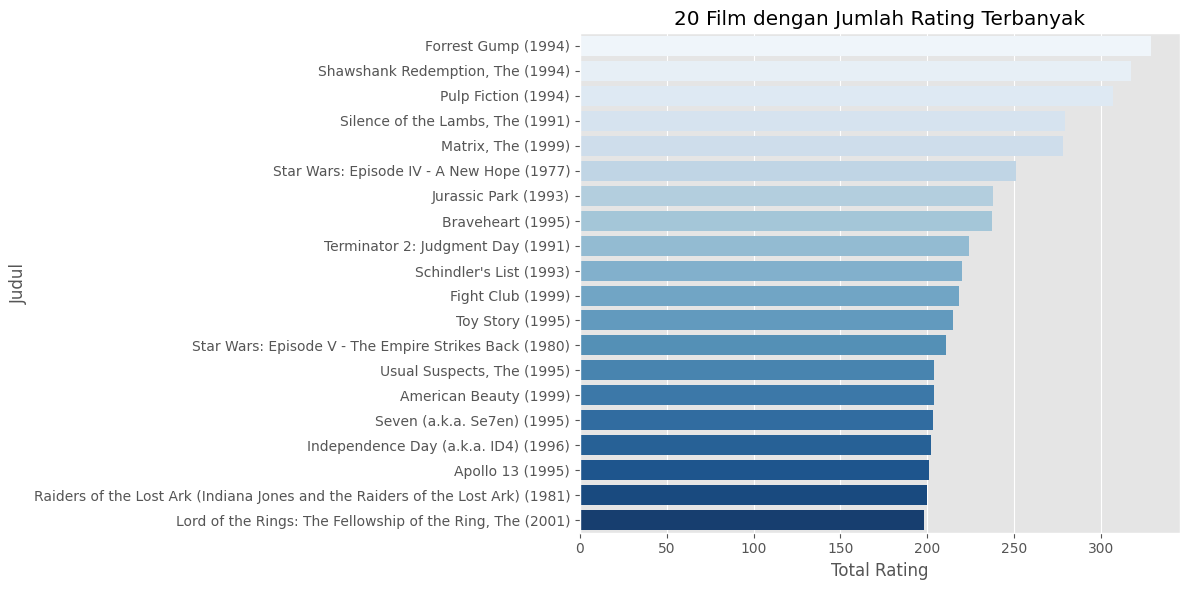

In [182]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_rated_films.head(20), x='total_rating', y='title', hue='title', palette='Blues', legend=False)
plt.title('20 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Total Rating')
plt.ylabel('Judul')
plt.tight_layout()
plt.show()

Secara keseluruhan, grafik ini menggambarkan film-film yang paling sering diulas atau diberi rating oleh pengguna, menyoroti popularitas dan daya tarik abadi dari sejumlah film klasik, terutama dari era 1990-an. Data ini menunjukkan bahwa film-film klasik dari era tersebut sangat populer di kalangan pemberi rating, dan penonton secara umum cenderung memberikan ulasan yang positif atau sangat baik terhadap film-film yang mereka tonton. Dalam dataset ini, film-film populer yang paling banyak mendapatkan rating, seperti "Forrest Gump," "Shawshank Redemption," dan "Pulp Fiction," didominasi oleh rilis tahun 1990-an, terutama dari tahun 1994, yang menunjukkan daya tarik abadi dari karya-karya klasik tersebut. Meskipun mencakup berbagai genre, daftar film dengan rating terbanyak ini secara tidak langsung merefleksikan popularitas tinggi di kalangan penonton aktif yang memberikan rating, dengan rentang jumlah rating antara 200 hingga lebih dari 300.

Menampilkan 20 Pengguna Teraktif dalam Memberikan Rating

In [183]:
ratings_per_user = ratings['userId'].value_counts()
most_active_users = ratings_per_user.sort_values(ascending=False)

print("20 Pengguna Teraktif dalam Memberikan Rating:")
print(most_active_users.head(20))

20 Pengguna Teraktif dalam Memberikan Rating:
userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
249    1046
387    1027
182     977
307     975
603     943
298     939
177     904
318     879
232     862
480     836
Name: count, dtype: int64


Visualisasi 20 pengguna teraktif

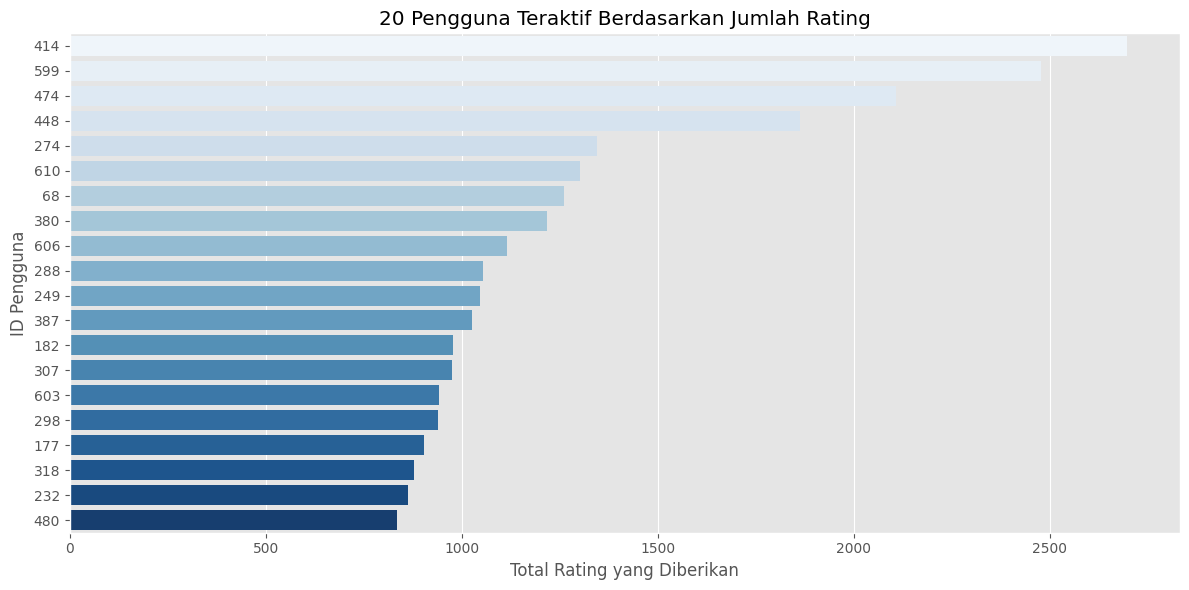

In [184]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=most_active_users.head(20).values,
    y=most_active_users.head(20).index.astype(str),
    hue=most_active_users.head(20).index.astype(str),
    palette='Blues',
    legend=False
)
plt.title('20 Pengguna Teraktif Berdasarkan Jumlah Rating')
plt.xlabel('Total Rating yang Diberikan')
plt.ylabel('ID Pengguna')
plt.tight_layout()
plt.show()

Secara keseluruhan, grafik ini mengungkapkan bahwa platform rating film ini memiliki sejumlah kecil pengguna yang sangat aktif dan berdedikasi yang berkontribusi secara signifikan terhadap volume data rating. Kondisi ini berimplikasi pada potensi bias dalam statistik keseluruhan, karena preferensi atau karakteristik rating dari kelompok inti pengguna ini dapat secara signifikan memengaruhi tren yang diamati. Oleh karena itu, saat menganalisis data dari platform ini, sangat krusial untuk memahami bahwa meskipun volume rating tinggi, distribusinya tidak merata dan sangat bergantung pada kontribusi berharga dari segelintir pengguna inti tersebut.

Visualisasi 20 genre film yang paling sering muncul

<ipython-input-185-cb5d5284da77>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_genres.index, x=top_genres.values, palette='Blues_r')


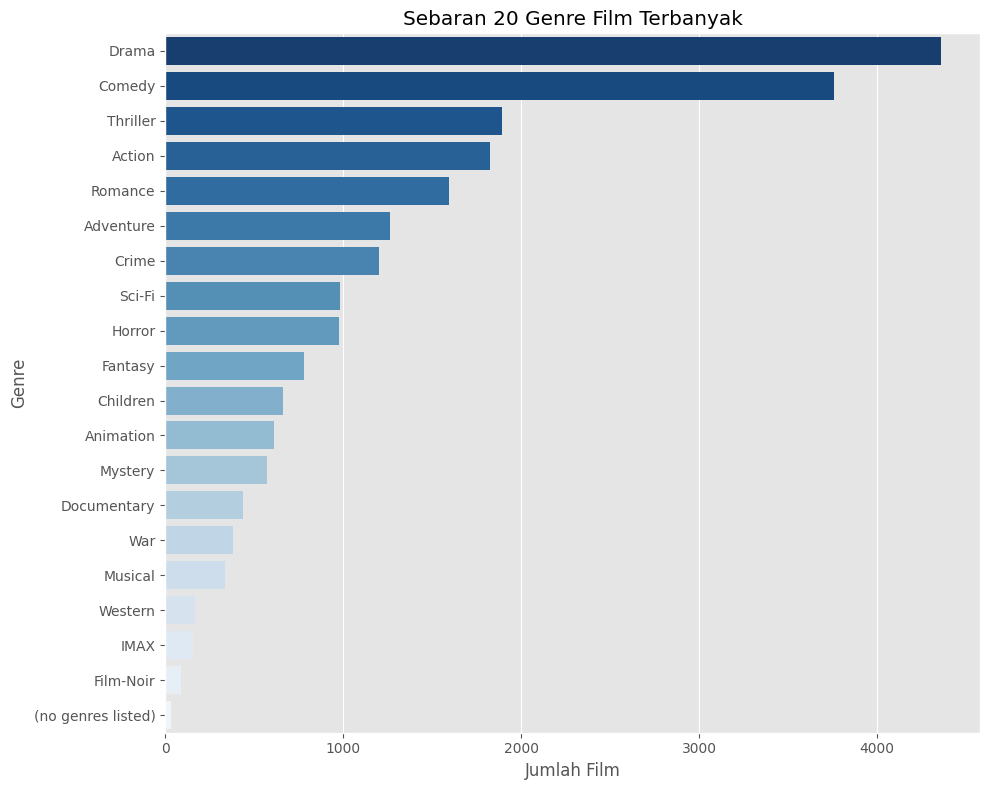

In [185]:
# Ubah kolom 'genres' menjadi format satu genre per baris
genre_per_row = movies['genres'].str.split('|').explode()
genre_frequencies = genre_per_row.value_counts()

top_genres = genre_frequencies.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(y=top_genres.index, x=top_genres.values, palette='Blues_r')

plt.title('Sebaran 20 Genre Film Terbanyak')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Secara keseluruhan, grafik ini dengan jelas menunjukkan bahwa genre Drama dan Comedy adalah pilar utama dalam kumpulan data film ini, diikuti oleh genre populer lainnya seperti Thriller dan Action, sementara banyak genre lain memiliki representasi yang jauh lebih kecil. Dalam dataset film ini, genre Drama dan Comedy mendominasi dengan jumlah film masing-masing melebihi dan mendekati 4000, menunjukkan produktivitas atau popularitas yang signifikan. Genre seperti Thriller dan Action juga memiliki representasi kuat dengan sekitar 1800-2000 film. Namun, terdapat rentang popularitas yang luas, di mana genre minoritas seperti Film-Noir, IMAX, Western, dan Musical memiliki jumlah film yang jauh lebih sedikit, hanya beberapa ratus atau kurang. Perbedaan ini menyoroti fokus industri pada genre tertentu, yang penting untuk dipertimbangkan dalam sistem rekomendasi guna memastikan variasi dan relevansi genre minoritas bagi pengguna.

## Data Preparation

Menggabungkan Dataset yang digunakan (ratings dan movies)

In [186]:
movies_ratings = pd.merge(ratings, movies, on='movieId')

In [187]:
movies_ratings.shape

(100836, 6)

In [188]:
print('Jumlah seluruh data: ', len(movies_ratings))

Jumlah seluruh data:  100836


In [189]:
movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Mengecek duplikat data dari data yang telah digabungkan

In [190]:
dupes = movies_ratings.duplicated()

print("Jumlah baris duplikat:", dupes.sum())
print(movies_ratings[dupes].head())

Jumlah baris duplikat: 0
Empty DataFrame
Columns: [userId, movieId, rating, timestamp, title, genres]
Index: []


Cek missing value dengan fungsi isnull()

In [191]:
movies_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


In [192]:
final = movies_ratings[['userId', 'movieId', 'title', 'genres', 'rating']]
final.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0
2,1,6,Heat (1995),Action|Crime|Thriller,4.0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0


In [193]:
final.shape

(100836, 5)

In [194]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   title    100836 non-null  object 
 3   genres   100836 non-null  object 
 4   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [195]:
# Mengecek missing values
final.isnull().sum()

,0
userId,0
movieId,0
title,0
genres,0
rating,0


In [196]:
#Mengecek apakah ada data duplikat
print('Jumlah data duplikat:', final.duplicated().sum())

Jumlah data duplikat: 0


In [197]:
duplikat = final[final.duplicated()]
print(duplikat)

Empty DataFrame
Columns: [userId, movieId, title, genres, rating]
Index: []


## Model Development Content Based Filtering

In [198]:
data = final.copy()
data.sample(5)

,userId,movieId,title,genres,rating
88449,571,1623,Wishmaster (1997),Horror,2.0
4295,28,1253,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi|Thriller,3.5
28819,199,3977,Charlie's Angels (2000),Action|Comedy,2.0
83377,528,7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller,3.5
23884,166,527,Schindler's List (1993),Drama|War,4.5


**TF-IDF Vectorization**

Filter metadata film sebanyak sampel 5000 rating.

In [199]:
sampled_data = data.sample(n=5000, random_state=42).reset_index(drop=True)
sampled_movie_ids = sampled_data['movieId'].unique()
filtered_movies = movies[movies['movieId'].isin(sampled_movie_ids)].reset_index(drop=True)

Menghapus label kosong dan mengganti pemisah genre '|' dengan spasi di kolom genres.

In [200]:
movies['genres'] = movies['genres'].replace('(no genres listed)', '', regex=False).str.replace('|', ' ', regex=False)

Mengubah daftar genre film menjadi representasi numerik TF-IDF

In [201]:
tfv = TfidfVectorizer()
tfv.fit(movies['genres'])

TfidfVectorizer()

In [202]:
tfv.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

Menghitung dan menyimpan matriks TF-IDF dari genre film

In [203]:
tfidf_matrix = tfv.fit_transform(movies['genres'])

In [204]:
tfidf_matrix.shape

(9742, 21)

Buat DataFrame TF-IDF genre per film dan tampilkan sampel.

In [205]:
tfidf_dense = tfidf_matrix.todense()

tfidf_df = pd.DataFrame(
    tfidf_dense,
    columns=tfv.get_feature_names_out(),
    index=movies['title']
)

tfidf_df.sample(20, axis=0).sample(10, axis=1)

,crime,western,horror,mystery,fi,children,war,thriller,documentary,drama
title,,,,,,,,,,
200 Cigarettes (1999),0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.678466
"House of the Devil, The (2009)",0.000000,0.0,0.780971,0.000000,0.000000,0.00000,0.0,0.624567,0.0,0.000000
Knock Knock (2015),0.591067,0.0,0.629949,0.000000,0.000000,0.00000,0.0,0.503790,0.0,0.000000
Midnight in the Garden of Good and Evil (1997),0.589949,0.0,0.000000,0.730552,0.000000,0.00000,0.0,0.000000,0.0,0.343880
"Glass Menagerie, The (1987)",0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,1.000000
How Stella Got Her Groove Back (1998),0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.540377
"War of the Roses, The (1989)",0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.678466
"Lawnmower Man, The (1992)",0.000000,0.0,0.482581,0.000000,0.482283,0.00000,0.0,0.385935,0.0,0.000000
Baadasssss! (How to Get the Man's Foot Outta Your Ass) (2003),0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,1.000000


**Cosine Similarity**

Membuat dan menampilkan matriks kemiripan film berdasarkan genre menggunakan cosine similarity.

In [206]:
cosine_sim = cosine_similarity(tfidf_matrix)

df_cosine_sim = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', df_cosine_sim.shape)

df_cosine_sim.sample(10, axis=1).sample(20, axis=0)

Shape: (9742, 9742)


title,Blue Valentine (2010),Tombstone (1993),"Man with Two Brains, The (1983)",Woyzeck (1979),Willy Wonka & the Chocolate Factory (1971),"Awfully Big Adventure, An (1995)",Nothing (2003),Welcome to Me (2014),Kingsman: The Golden Circle (2017),Identity (2003)
title,,,,,,,,,,
Anti-Social (2015),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476957
Himalaya (Himalaya - l'enfance d'un chef) (1999),0.275575,0.153290,0.000000,0.509968,0.000000,0.509968,0.000000,0.345996,0.582073,0.000000
Trees Lounge (1996),0.540377,0.300587,0.000000,1.000000,0.000000,1.000000,0.000000,0.678466,0.000000,0.000000
Earth Girls Are Easy (1988),0.000000,0.000000,0.292310,0.000000,0.490356,0.000000,0.526816,0.214740,0.126974,0.000000
Rising Sun (1993),0.194621,0.345998,0.000000,0.360159,0.000000,0.360159,0.404062,0.244355,0.317292,0.451912
"Day After, The (1983)",0.195017,0.108479,0.000000,0.360892,0.000000,0.360892,0.599083,0.244853,0.000000,0.000000
European Vacation (aka National Lampoon's European Vacation) (1985),0.516199,0.000000,0.426605,0.000000,0.119123,0.000000,0.114824,0.313398,0.635005,0.000000
Chocolat (1988),0.540377,0.300587,0.000000,1.000000,0.000000,1.000000,0.000000,0.678466,0.000000,0.000000
Alan Partridge: Alpha Papa (2013),0.000000,0.000000,1.000000,0.000000,0.279236,0.000000,0.269158,0.734632,0.434380,0.000000


Mendapatkan Rekomendasi

In [207]:
def movie_recommendations(judul_film, similarity_data=df_cosine_sim, items=movies[['title', 'genres']], k=10):
    """
    Rekomendasi Film berdasarkan kemiripan DataFrame

    Parameter:
    ---
    judul_film : str
        Judul film (harus ada sebagai index/kolom di similarity_data)
    similarity_data : pd.DataFrame
        Matriks kemiripan (similarity matrix) simetris dengan judul film sebagai index dan kolom
    items : pd.DataFrame
        DataFrame yang memuat informasi film, minimal kolom 'title' dan fitur lain (misal genre)
    k : int, default=5
        Jumlah film rekomendasi yang ingin ditampilkan

    ---
    Fungsi ini mengembalikan DataFrame berisi k film yang paling mirip dengan judul_film
    berdasarkan matriks kemiripan similarity_data, disertai metadata film dari items.
    """

    index = similarity_data.loc[:, judul_film].to_numpy().argpartition(range(-1, -k-1, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(judul_film, errors='ignore')

    closest_df = pd.DataFrame(closest, columns=['title'])

    return closest_df.merge(items, on='title').head(k)

 Melihat detail film yang akan direkomendasikan

In [208]:
movies[movies['title'].str.contains('Mad Max (1979)', case=False, regex=False)]

,movieId,title,genres
2764,3702,Mad Max (1979),Action Adventure Sci-Fi


Memanggil fungsi untuk memberikan rekomendasi film mirip dengan "Mad Max (1979)"

In [209]:
movie_recommendations('Mad Max (1979)')

,title,genres
0,Lost in Space (1998),Action Adventure Sci-Fi
1,Waterworld (1995),Action Adventure Sci-Fi
2,"Time Machine, The (2002)",Action Adventure Sci-Fi
3,Logan's Run (1976),Action Adventure Sci-Fi
4,Transformers: Age of Extinction (2014),Action Adventure Sci-Fi
5,Power/Rangers (2015),Action Adventure Sci-Fi
6,Spacehunter: Adventures in the Forbidden Zone ...,Action Adventure Sci-Fi
7,Tron (1982),Action Adventure Sci-Fi
8,Assassin's Creed (2016),Action Adventure Sci-Fi
9,Iron Man (2008),Action Adventure Sci-Fi


In [210]:
movie_recommendations('Against All Odds (1984)')

,title,genres
0,Temptress Moon (Feng Yue) (1996),Romance
1,Meet Joe Black (1998),Romance
2,Kama Sutra: A Tale of Love (1996),Romance
3,Love Jones (1997),Romance
4,Anything for Love (2016),Romance
5,"Paris, I Love You (Paris, je t'aime) (2006)",Romance
6,Message in a Bottle (1999),Romance
7,'Tis the Season for Love (2015),Romance
8,Jack and Sarah (1995),Romance
9,Open Hearts (Elsker dig for evigt) (2002),Romance


In [211]:
movie_recommendations('Last Train Home (2009)')

,title,genres
0,Seve (2014),Documentary Drama
1,Rude Boy (1980),Documentary Drama
2,Sicko (2007),Documentary Drama
3,"Blood of the Beasts (Sang des bêtes, Le) (1949)",Documentary Drama
4,"Story of the Weeping Camel, The (Geschichte vo...",Documentary Drama
5,Titicut Follies (1967),Documentary Drama
6,Looking for Richard (1996),Documentary Drama
7,On the Ropes (1999),Documentary Drama
8,Pirates of Silicon Valley (1999),Documentary Drama
9,Oceans (Océans) (2009),Documentary Drama


Evaluasi Precision@k untuk Cosine Similarity

In [246]:
def precision_at_k(recommended_movies, relevant_movies, k):
    """
    Menghitung Precision@k.

    Args:
      recommended_movies: List film yang direkomendasikan.
      relevant_movies: List film relevan (ground truth).
      k: Jumlah film teratas yang dipertimbangkan.

    Returns:
      float: Nilai Precision@k.
    """
    if k == 0 or not recommended_movies:
        return 0.0

    recommended_at_k = recommended_movies[:k]
    relevant_found = [movie for movie in recommended_at_k if movie in relevant_movies]

    return len(relevant_found) / k


# Simulasi Data Hasil Rekomendasi (Cosine Similarity)
recommendations_cosine = {
    'Mad Max (1979)': movie_recommendations('Mad Max (1979)')['title'].tolist(),
    'Against All Odds (1984)': movie_recommendations('Against All Odds (1984)')['title'].tolist(),
    'Last Train Home (2009)': movie_recommendations('Last Train Home (2009)')['title'].tolist(),
}

# Contoh data ground truth (film yang sebenarnya relevan)
ground_truth = {
    'Mad Max (1979)': [
        'Lost in Space (1998)',
        'Waterworld (1995)',
        'Time Machine, The (2002)',
        "Logan's Run (1976)",
        'Transformers: Age of Extinction (2014)',
        'Power/Rangers (2015)',
        'Spacehunter: Adventures in the Forbidden Zone (1983)',
        'Tron (1982)',
        "Assassin's Creed (2016)",
        'Iron Man (2008)'
    ],
    'Against All Odds (1984)': [
        'Temptress Moon (Feng Yue) (1996)',
        'Meet Joe Black (1998)',
        'Kama Sutra: A Tale of Love (1996)',
        'Love Jones (1997)',
        'Anything for Love (2016)',
        "Paris, I Love You (Paris, je t'aime) (2006)",
        'Message in a Bottle (1999)',
        "'Tis the Season for Love (2015)",
        'Jack and Sarah (1995)',
        'Open Hearts (Elsker dig for evigt) (2002)'
    ],
    'Last Train Home (2009)': [
        'Seve (2014)',
        'Rude Boy (1980)',
        'Sicko (2007)',
        'Blood of the Beasts (Sang des bêtes, Le) (1949)',
        'Story of the Weeping Camel, The (Geschichte vom weinenden Kamel) (2003)',
        'Titicut Follies (1967)',
        'Looking for Richard (1996)',
        'On the Ropes (1999)',
        'Pirates of Silicon Valley (1999)',
        'Oceans (Océans) (2009)'
    ]
}

def evaluate_precision_for_all_movies(recommendation_data, ground_truth_data, k_values):
    """
    Mengevaluasi Precision@k rata-rata untuk banyak film input.

    Args:
      recommendation_data (dict): Dictionary {judul_film: list rekomendasi film}.
      ground_truth_data (dict): Dictionary {judul_film: list film relevan}.
      k_values (list): List nilai k yang ingin dievaluasi.

    Returns:
      pd.DataFrame: DataFrame berisi rata-rata Precision@k untuk setiap nilai k.
    """
    results = {}
    for k in k_values:
        total_precision = 0
        evaluated_movies_count = 0

        for movie_title, recommended_list in recommendation_data.items():
            if movie_title in ground_truth_data:
                relevant_list = ground_truth_data[movie_title]
                if relevant_list:
                    precision_val = precision_at_k(recommended_list, relevant_list, k)
                    total_precision += precision_val
                    evaluated_movies_count += 1
            else:
                print(f"Peringatan: Tidak ada ground truth untuk film '{movie_title}'. Dilewati.")

        average_precision = total_precision / evaluated_movies_count if evaluated_movies_count > 0 else 0
        results[f'Precision@{k}'] = average_precision

    return pd.DataFrame([results])

# Nilai k yang ingin dievaluasi
k_to_evaluate = [1, 3, 5, 10]

# Menampilkan hasil evaluasi Precision@k
print("Evaluasi Precision@k untuk Cosine Similarity\n")
cosine_precision_results = evaluate_precision_for_all_movies(
    recommendations_cosine,
    ground_truth,
    k_to_evaluate
)

print(cosine_precision_results)

Evaluasi Precision@k untuk Cosine Similarity

   Precision@1  Precision@3  Precision@5  Precision@10
0          1.0          1.0     0.933333      0.966667


## Model Development dengan Collaborative Filtering

In [213]:
df_ratings = ratings
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**Data Preparation Model Development dengan Collaborative Filtering**

Membuat encoding userID ke angka dan sebaliknya

In [214]:
user_ids = df_ratings['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Membuat encoding movieId ke angka dan sebaliknya

In [215]:
movie_ids = df_ratings['movieId'].unique().tolist()

# Melakukan proses encoding placeID
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke placeID
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)

encoded angka ke movieId:  {0: 1, 1: 3, 2: 6, 3: 47, 4: 50, 5: 70, 6: 101, 7: 110, 8: 151, 9: 157, 10: 163, 11: 216, 12: 223, 13: 231, 14: 235, 15: 260, 16: 296, 17: 316, 18: 333, 19: 349, 20: 356, 21: 362, 22: 367, 23: 423, 24: 441, 25: 457, 26: 480, 27: 500, 28: 527, 29: 543, 30: 552, 31: 553, 32: 590, 33: 592, 34: 593, 35: 596, 36: 608, 37: 648, 38: 661, 39: 673, 40: 733, 41: 736, 42: 780, 43: 804, 44: 919, 45: 923, 46: 940, 47: 943, 48: 954, 49: 1009, 50: 1023, 51: 1024, 52: 1025, 53: 1029, 54: 1030, 55: 1031, 56: 1032, 57: 1042, 58: 1049, 59: 1060, 60: 1073, 61: 1080, 62: 1089, 63: 1090, 64: 1092, 65: 1097, 66: 1127, 67: 1136, 68: 1196, 69: 1197, 70: 1198, 71: 1206, 72: 1208, 73: 1210, 74: 1213, 75: 1214, 76: 1219, 77: 1220, 78: 1222, 79: 1224, 80: 1226, 81: 1240, 82: 1256, 83: 1258, 84: 1265, 85: 1270, 86: 1275, 87: 1278, 88: 1282, 89: 1291, 90: 1298, 91: 1348, 92: 1377, 93: 1396, 94: 1408, 95: 1445, 96: 1473, 97: 1500, 98: 1517, 99: 1552, 100: 1573, 101: 1580, 102: 1587, 103: 16

Mengubah userId dan movieId ke format encoded di dataframe.

In [216]:
df_ratings['user'] = df_ratings['userId'].map(user_to_user_encoded)
df_ratings['movie'] = df_ratings['movieId'].map(movie_to_movie_encoded)

Menghitung user, film, dan menampilkan info rating

In [217]:
num_users = len(user_to_user_encoded)
num_movie = len(movie_to_movie_encoded)

df_ratings['rating'] = df_ratings['rating'].values.astype(np.float32)

min_rating = min(df_ratings['rating'])
max_rating = max(df_ratings['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Mengacak urutan data df_ratings

In [218]:
df = df_ratings.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


Mempersiapkan data input (user, movie) dan target rating yang sudah dinormalisasi, lalu membagi jadi data train dan validasi.

In [219]:
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Membangun Model Colaborative Filtering

In [220]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, output_activation='sigmoid', **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.output_activation = output_activation

        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

        self.dot = layers.Dot(axes=1)
        self.dropout = layers.Dropout(0.3)

    def call(self, inputs):
        user_vec = self.dropout(self.user_embedding(inputs[:, 0]))
        user_bias = self.user_bias(inputs[:, 0])

        movie_vec = self.dropout(self.movie_embedding(inputs[:, 1]))
        movie_bias = self.movie_bias(inputs[:, 1])

        x = self.dot([user_vec, movie_vec]) + user_bias + movie_bias

        return tf.nn.sigmoid(x) if self.output_activation == 'sigmoid' else x

Membuat callback untuk menghentikan pelatihan jika validasi loss tidak membaik selama 3 epoch.









In [221]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,             # Hentikan jika 3 epoch berturut-turut val_loss tidak membaik
    restore_best_weights=True,  # Kembalikan bobot ke yang terbaik (bukan terakhir)
    verbose=1
)

Membuat dan menyiapkan model rekomendasi untuk pelatihan.

In [222]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Melatih model dengan data training dan validasi.

In [223]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),  # pastikan kamu split validation set
    callbacks=[early_stopping]
)

Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.6914 - root_mean_squared_error: 0.2856 - val_loss: 0.6847 - val_root_mean_squared_error: 0.2775
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6814 - root_mean_squared_error: 0.2761 - val_loss: 0.6762 - val_root_mean_squared_error: 0.2697
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.6723 - root_mean_squared_error: 0.2672 - val_loss: 0.6681 - val_root_mean_squared_error: 0.2621
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6633 - root_mean_squared_error: 0.2573 - val_loss: 0.6596 - val_root_mean_squared_error: 0.2540
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.6531 - root_mean_squared_error: 0.2480 - val_loss: 0.6502 - val_root_mean_squared_error: 0.2447
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.6420 - root_mean_squared_error: 0.2373 - val_loss: 0.6405 - val_root_mean_squared_error: 0.2349
Epoch 7/100
1261/1261 ━━━━━

Visualisasi RMSE training dan validation tiap epoch.

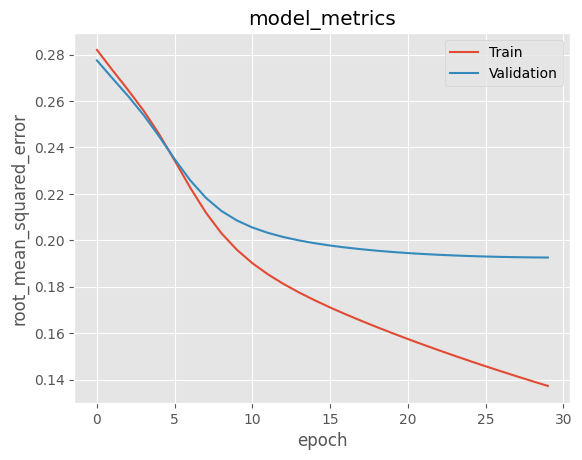

In [224]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

Membuat input (user, film belum ditonton) untuk prediksi rekomendasi.

In [225]:
movie_df = movies
ratings_df = ratings

# Ambil satu userId secara acak dari data rating
user_id = ratings_df.userId.sample(1).iloc[0]

# Ambil semua film yang sudah ditonton oleh user tersebut (dari data rating)
movies_watched_by_user = ratings_df[ratings_df.userId == user_id]

# Ambil semua movieId dari daftar film yang belum ditonton oleh user
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

# Filter ulang agar hanya menyertakan film yang ada dalam movie_to_movie_encoded
movies_not_watched = list(set(movies_not_watched).intersection(set(movie_to_movie_encoded.keys())))

# Encode movieId (ubah movieId asli jadi indeks encoding), lalu jadikan bentuk array dua dimensi [[movie_id]]
movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]

# Ambil userId hasil encoding (sudah dilatih sebelumnya)
user_encoder = user_to_user_encoded.get(user_id)

# Gabungkan user encoded ID dengan daftar film yang belum ditonton
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

Memprediksi dan menampilkan 10 rekomendasi film terbaik untuk user berdasarkan model serta 5 film favorit user dari data asli.

In [226]:
ratings = model.predict(user_movie_array).flatten()

# Ambil indeks 10 prediksi tertinggi (argsort() dari kecil ke besar → dibalik)
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Ambil movieId asli dari indeks film hasil prediksi
recommended_movie_ids = [
    movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# Tampilkan userId yang sedang diproses dalam format misal: U0015
print(f"Showing recommendations for users: U{user_id:04d}")
print("=" * 30)

# Film dengan rating tertinggi dari user tersebut
print("\nFilm with high ratings from user")
print("-" * 30)

# Ambil 5 film tertinggi yang pernah di-rating user ini
top_movies = (
    movies_watched_by_user.sort_values(by='rating', ascending=False)
    .head(5)
    .movieId.values
)

# Tampilkan judul dari 5 film tertinggi tersebut
for m in movie_df[movie_df.movieId.isin(top_movies)].itertuples():
    print(f"{m.title}")

print("\nTop 10 movie recommendation")
print("-" * 30)

for m in movie_df[movie_df.movieId.isin(recommended_movie_ids)].itertuples():
    print(f"{m.title}")

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Showing recommendations for users: U0186

Film with high ratings from user
------------------------------
Santa Clause, The (1994)
Aladdin (1992)
Silence of the Lambs, The (1991)
Beauty and the Beast (1991)
Breakfast at Tiffany's (1961)

Top 10 movie recommendation
------------------------------
Usual Suspects, The (1995)
Braveheart (1995)
Pulp Fiction (1994)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Schindler's List (1993)
Godfather, The (1972)
Rear Window (1954)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)
12 Angry Men (1957)
